In [9]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import os
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Carga de los datos y exploración
current_dir = os.getcwd()
data_path = os.path.join(current_dir, '..', 'data', 'heart.csv')
data_path = os.path.abspath(data_path)

data = pd.read_csv(data_path)

print(data.head())
print(data.info())
print(data.describe())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

In [14]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

for col in categorical_columns:
    print(f"--- {col} ---")
    print(data[col].value_counts())
    print("\n")
    
# for col in categorical_columns:
#     plt.figure(figsize=(8, 4))
#     sns.countplot(x=col, data=data)
#     plt.title(f"Distribution of {col}")
#     plt.show()

--- Sex ---
Sex
M    725
F    193
Name: count, dtype: int64


--- ChestPainType ---
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64


--- RestingECG ---
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64


--- ExerciseAngina ---
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64


--- ST_Slope ---
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


--- HeartDisease ---
HeartDisease
1    508
0    410
Name: count, dtype: int64




In [3]:
# 2. Preprocesamiento de Datos
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_features = data.drop(columns=['HeartDisease'] + categorical_features).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [4]:
# 3. Feature Engineering
feature_engineering = Pipeline(steps=[
    ('pca', PCA(n_components=10))
])

# 4. Entrenamiento del Modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_engineering', feature_engineering),
    ('classifier', SVC(probability=True, random_state=42))
])

X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('feature_engineering',
                 Pipeline(steps=[('pca', PCA(n_components=10))])),
                ('classifier', SVC(probability=True, random_state=42))])

{'Accuracy': 0.9057971014492754, 'Precision': np.float64(0.8944099378881988), 'Recall': np.float64(0.9411764705882353), 'F1 Score': np.float64(0.9171974522292994), 'ROC AUC Score': np.float64(0.953876401509113)}


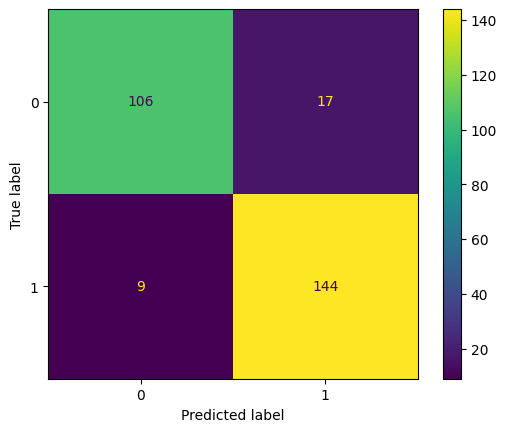

In [13]:
# 5. Evaluación del Modelo
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC Score': roc_auc_score(y_test, y_prob)
}

pipeline_path = os.path.join('..', 'models', 'pipeline.pkl')
joblib.dump(pipeline, pipeline_path)

print(results)

conf_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()